In [90]:
import os
import shutil
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
source_dir = '/kaggle/input/leapgestrecog/leapGestRecog'
destination_dir = '/kaggle/working/leapGestRecogOrganized'

In [3]:
gesture_folders = [
    "01_palm", "02_l", "03_fist", "04_fist_moved", "05_thumb",
    "06_index", "07_ok", "08_palm_moved", "09_c", "10_down"
]

In [4]:
for gesture in gesture_folders:
    os.makedirs(os.path.join(destination_dir, gesture), exist_ok=True)

In [5]:
for i in range(10):
    source_subfolder = os.path.join(source_dir, f"{i:02}")
    
    for gesture in gesture_folders:
        gesture_folder_path = os.path.join(source_subfolder, gesture)
        
        if os.path.exists(gesture_folder_path):
            for image_file in os.listdir(gesture_folder_path):
                image_path = os.path.join(gesture_folder_path, image_file)
                
                destination_path = os.path.join(destination_dir, gesture, image_file)
                
                shutil.copy(image_path, destination_path)
                
print("Images have been successfully organized.")

Images have been successfully organized.


In [7]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
data_dir = '/kaggle/working/leapGestRecogOrganized'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [12]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [79]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [80]:
model = CNN()

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)

In [91]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    loader_tqdm = tqdm(loader, desc="Training", leave=False)
    
    for inputs, labels in loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        loader_tqdm.set_postfix(batch_loss=loss.item())
    
    epoch_loss = running_loss / len(loader)
    return epoch_loss

In [92]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    loader_tqdm = tqdm(loader, desc="Validating", leave=False)
    
    with torch.no_grad():
        for inputs, labels in loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loader_tqdm.set_postfix(batch_loss=loss.item())

    accuracy = 100 * correct / total
    epoch_loss = running_loss / len(loader)
    return epoch_loss, accuracy

In [93]:
save_dir = "/kaggle/working/best_model"
os.makedirs(save_dir, exist_ok=True)
best_model_path = os.path.join(save_dir, "gesture_cnn_best.pth")

In [97]:
num_epochs = 10
best_val_accuracy = 0.0

In [98]:
train_losses = []
val_losses = []

In [99]:
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    scheduler.step()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")
    
print(f"Training complete. Best validation accuracy: {best_val_accuracy:.2f}%")
print(f"Best model saved at: {best_model_path}")

Epoch [1/10], Train Loss: 0.2849, Val Loss: 0.0405, Val Accuracy: 98.88%


Epoch [2/10], Train Loss: 0.2324, Val Loss: 0.0630, Val Accuracy: 98.58%


Epoch [3/10], Train Loss: 0.0774, Val Loss: 0.0201, Val Accuracy: 99.47%


Epoch [4/10], Train Loss: 0.0684, Val Loss: 0.0324, Val Accuracy: 99.38%


Epoch [5/10], Train Loss: 0.0624, Val Loss: 0.0178, Val Accuracy: 99.65%


Epoch [6/10], Train Loss: 0.0708, Val Loss: 0.0465, Val Accuracy: 98.65%


Epoch [7/10], Train Loss: 0.1679, Val Loss: 0.0265, Val Accuracy: 99.22%


Epoch [8/10], Train Loss: 0.0379, Val Loss: 0.0162, Val Accuracy: 99.70%


Epoch [9/10], Train Loss: 0.0314, Val Loss: 0.0142, Val Accuracy: 99.65%


Epoch [10/10], Train Loss: 0.0238, Val Loss: 0.0091, Val Accuracy: 99.78%
Training complete. Best validation accuracy: 99.78%
Best model saved at: /kaggle/working/best_model/gesture_cnn_best.pth


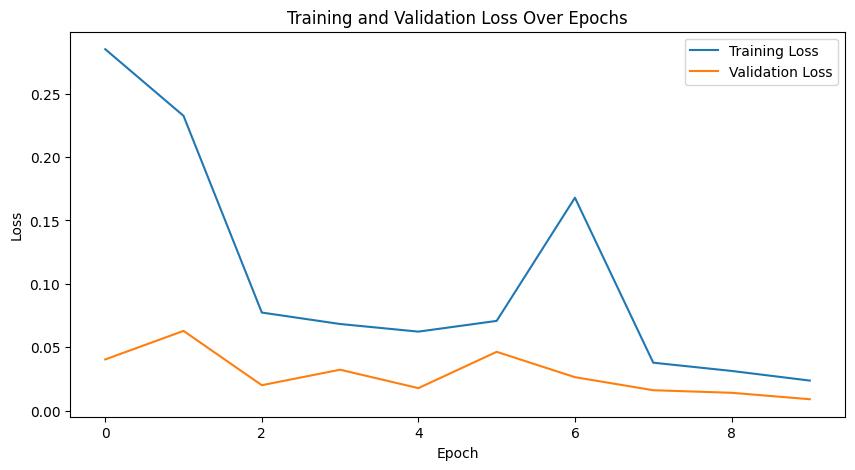

In [100]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()